<a href="https://colab.research.google.com/github/Bazinga97/ML_Projects/blob/main/Learning_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.5 MB/s eta 0:00:00


## Tiktoken:

# Library by openAI for tokenizing text; process of breaking string into smaller componets called tokens so that model can understand

In [2]:
from importlib.metadata import version

print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

torch version: 2.3.1+cu121
tiktoken version: 0.7.0


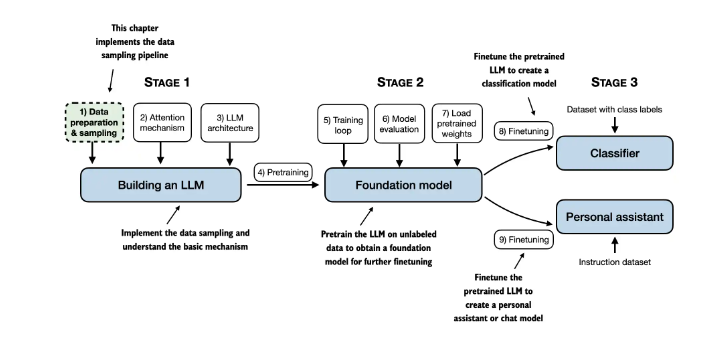

## **Embeddings: **



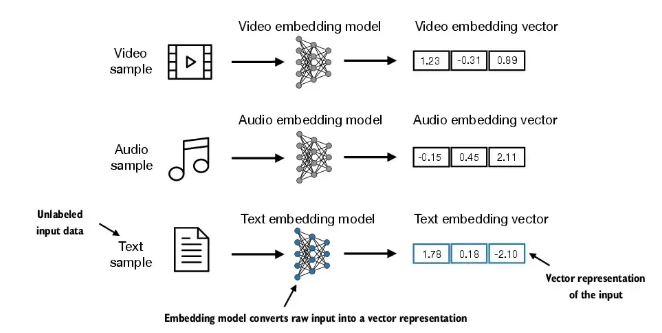

## tokenize text:  breaking text into smaller units, such as individual words and punctuation characters

In [3]:

import os
import urllib.request

if not os.path.exists("the-verdict.txt"):
    url = ("https://raw.githubusercontent.com/rasbt/"
           "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
           "the-verdict.txt")
    file_path = "the-verdict.txt"
    urllib.request.urlretrieve(url, file_path)

In [4]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

print("Total number of character:", len(raw_text))
print(raw_text[:99])

Total number of character: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [5]:
import re

text = "Hello, world. This, is a test."
result = re.split(r'(\s)', text)

print(result)

['Hello,', ' ', 'world.', ' ', 'This,', ' ', 'is', ' ', 'a', ' ', 'test.']


In [6]:
result = re.split(r'([,.]|\s)', text)

print(result)

['Hello', ',', '', ' ', 'world', '.', '', ' ', 'This', ',', '', ' ', 'is', ' ', 'a', ' ', 'test', '.', '']


In [7]:

# Strip whitespace from each item and then filter out any empty strings.
result = [item for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'This', ',', 'is', 'a', 'test', '.']


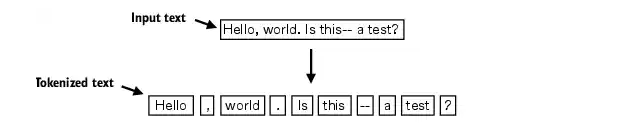

In [8]:
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(preprocessed[:30])

['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


In [9]:

print(len(preprocessed))

4690


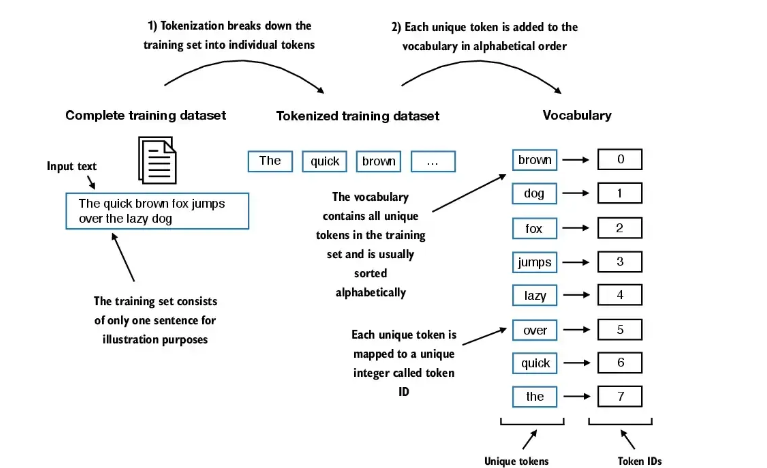

In [10]:
all_words = sorted(set(preprocessed))
vocab_size = len(all_words)

print(vocab_size)

1130


# Key-value pair consists of a token (word) and its corresponding integer index

In [11]:
vocab = {token:integer for integer,token in enumerate(all_words)}

In [12]:

for i, item in enumerate(vocab.items()):
    print(item)
    if i >= 50:
        break

('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)
('Burlington', 21)
('But', 22)
('By', 23)
('Carlo', 24)
('Chicago', 25)
('Claude', 26)
('Come', 27)
('Croft', 28)
('Destroyed', 29)
('Devonshire', 30)
('Don', 31)
('Dubarry', 32)
('Emperors', 33)
('Florence', 34)
('For', 35)
('Gallery', 36)
('Gideon', 37)
('Gisburn', 38)
('Gisburns', 39)
('Grafton', 40)
('Greek', 41)
('Grindle', 42)
('Grindles', 43)
('HAD', 44)
('Had', 45)
('Hang', 46)
('Has', 47)
('He', 48)
('Her', 49)
('Hermia', 50)


Encode: Text to Token IDs conversion


Decode: Token IDs to text



# We can use the tokenizer to encode (that is, tokenize) texts into integers
# These integers can then be embedded (later) as input of/for the LLM

In [13]:

class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s,i in vocab.items()}

    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)

        preprocessed = [
            item.strip() for item in preprocessed if item.strip()
        ]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

In [14]:
tokenizer = SimpleTokenizerV1(vocab)

text = """"It's the last he painted, you know,"
           Mrs. Gisburn said with pardonable pride."""
ids = tokenizer.encode(text)
print(ids)

[1, 56, 2, 850, 988, 602, 533, 746, 5, 1126, 596, 5, 1, 67, 7, 38, 851, 1108, 754, 793, 7]


Addtion of special context tokens

In [15]:
tokenizer = SimpleTokenizerV1(vocab)

text = "Hello, do you like tea. Is this-- a test?"

tokenizer.encode(text)

KeyError: 'Hello'

In [16]:

all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>", "<|unk|>"])

vocab = {token:integer for integer,token in enumerate(all_tokens)}

In [17]:

len(vocab.items())

1132

In [18]:

for i, item in enumerate(list(vocab.items())[-5:]):
    print(item)

('younger', 1127)
('your', 1128)
('yourself', 1129)
('<|endoftext|>', 1130)
('<|unk|>', 1131)


In [22]:

class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = { i:s for s,i in vocab.items()}

    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        preprocessed = [
            item if item in self.str_to_int
            else "<|unk|>" for item in preprocessed
        ]

        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.:;?!"()\'])', r'\1', text)
        return text

In [23]:
tokenizer = SimpleTokenizerV2(vocab)

text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."

text = " <|endoftext|> ".join((text1, text2))

print(text)

Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.


In [24]:

tokenizer.encode(text)

[1131, 5, 355, 1126, 628, 975, 10, 1130, 55, 988, 956, 984, 722, 988, 1131, 7]

BytePair Encoding (BPE) Tokenizer: Used by GPT-2 to handle out-of-vocabulary words by breaking them into smaller subword units or characters.


Tiktoken's BPE tokenizer was about 5 times faster than the original implementation on a sample text.


# BPE tokenizers break down unknown words into subwords and individual characters:

In [25]:

import importlib
import tiktoken

print("tiktoken version:", importlib.metadata.version("tiktoken"))

tiktoken version: 0.7.0


In [26]:

tokenizer = tiktoken.get_encoding("gpt2")

In [27]:
text = (
    "Hello, do you like tea? <|endoftext|> In the sunlit terraces"
     "of someunknownPlace."
)

integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})

print(integers)

[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 1659, 617, 34680, 27271, 13]


In [28]:

strings = tokenizer.decode(integers)

print(strings)

Hello, do you like tea? <|endoftext|> In the sunlit terracesof someunknownPlace.
